# cml1 - Immobilienrechner
# 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vergleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.

### MAPE - Metrik

Der Mean Absolute Percentage Error (MAPE) ist eine Metrik zur Beurteilung der Genauigkeit von Vorhersagemodellen. MAPE gibt den durchschnittlichen prozentualen Fehler zwischen den beobachteten (tatsächlichen) Werten und den vorhergesagten Werten an. Er wird häufig in der Zeitreihenanalyse und bei Prognosemodellen verwendet, besonders wenn es wichtig ist, die Genauigkeit von Vorhersagen in Bezug auf die tatsächlichen Werte in Prozent auszudrücken.

Die Formel zur Berechnung von MAPE ist:

$$MAPE = \frac{1}{n} \sum_{i=1}^{n}\frac{|y_i - \hat{y}_i|}{y_i}* 100$$

wobei: 
- $y_i$ der tatsächliche Wert zum Zeitpunkt t ist.
- $\hat{y}_i$ der vorhergesagte Wert zum Zeitpunkt t ist.
- $n$ die Gesamtanzahl der Beobachtungen ist.

## Module importieren

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# tree models
from sklearn.tree import DecisionTreeRegressor

# ensemble models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# xgb model
import xgboost as xgb
from xgboost import XGBRegressor

# imputing
from sklearn.impute import SimpleImputer, KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

# pipeline
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

## Daten laden

In [4]:
df = pd.read_csv('../../../data/immo_data_clean.csv', low_memory=False)
print(df.shape)

(21466, 57)


## Daten vorbereiten

In [205]:
# create dummies for categorical features
df = pd.get_dummies(df, drop_first=True)

print(df.shape)

(21466, 104)


Durch die Erzeugung von Dummies bei den kategorischen Spalten, haben wir nun 104 Spalten.

## Korrelationen

In diesem Abschnitt werden wir hochkorrelierte Merkmale identifizieren. Dies ist ein wichtiger Schritt bei der Auswahl von Merkmalen. Die Logik dahinter ist, dass zwei (oder mehr) Variablen, die hoch korreliert sind, redundante Informationen enthalten, was für einige Algorithmen des maschinellen Lernens, insbesondere die lineare Regression, problematisch sein kann.

In [206]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# df without categorical columns
df_num = df.drop(categorical_cols, axis=1)

In [207]:
# Compute the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Find features that have a correlation greater than 0.8 with another feature
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features = list(highly_correlated_features)
highly_correlated_features

['gde_population',
 'gde_private_apartments',
 'RiversAndLakesM',
 'gde_workers_total',
 'WorkplaceDensityM',
 'WorkplaceDensityS',
 'NoisePollutionRailwayM',
 'PopulationDensityS',
 'ForestDensityS',
 'PopulationDensityM',
 'NoisePollutionRoadS',
 'gde_pop_per_km2',
 'NoisePollutionRoadM',
 'ForestDensityM']

Wir haben mehrere Merkmale identifiziert, die eine Korrelation von mehr als 0.8 mit mindestens einem anderen Merkmal aufweisen.

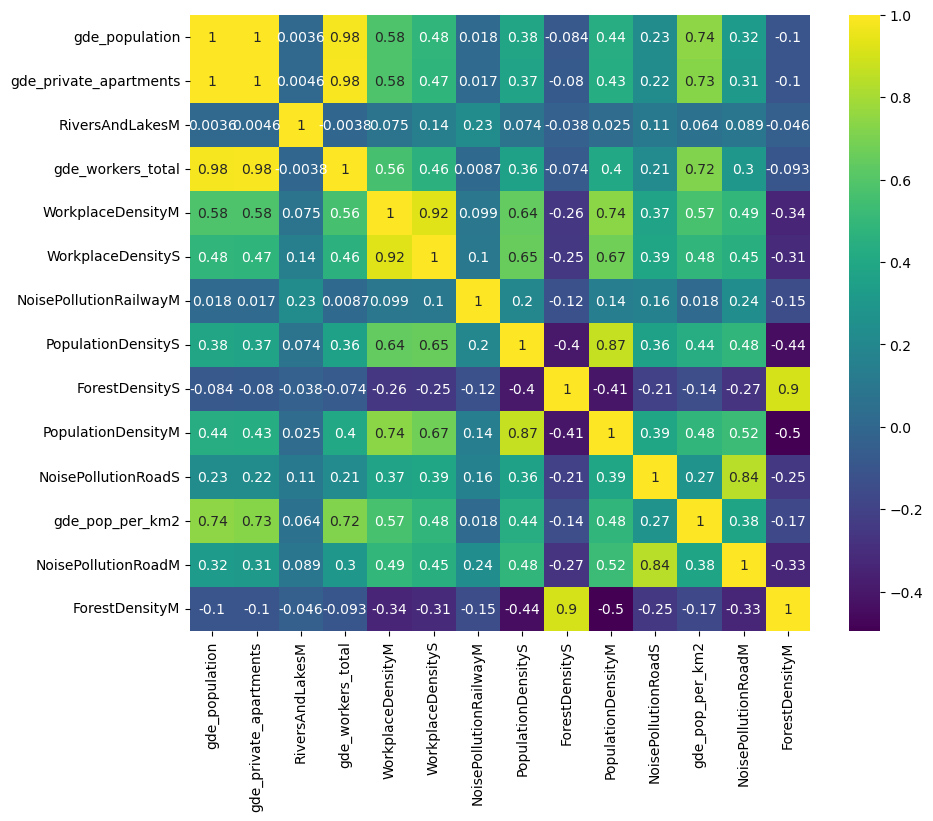

In [208]:
correlation_matrix = df_num[highly_correlated_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.show()

## Train Test Split

In [209]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

# split into X and y
X_train = train.drop("price_cleaned", axis=1)
y_train = train["price_cleaned"]

X_test = test.drop("price_cleaned", axis=1)
y_test = test["price_cleaned"]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (17172, 103)
y_train shape:  (17172,)
X_test shape:  (4294, 103)
y_test shape:  (4294,)


## Impuation

In [210]:
cols = X_train.columns

X_train_with_na = X_train.copy()
X_test_with_na = X_test.copy()

imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(imputer.transform(X_test), columns=cols)

## Standardisierung

In [211]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

## Feature Importance 
Um die Wichtigkeit jedes Merkmals zu bestimmen, verwenden wir die xgboost- und random forest-Bibliotheken und vergleichen dann die Ergebnisse.

### XGBoost

In [212]:
# Instantiate the XGBRegressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# fit the model
xg_reg.fit(X_train, y_train);

# Get F-scores from the XGBoost model
f_scores = xg_reg.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a dataframe and sort
df_xgb = pd.DataFrame(list(f_scores.items()), columns=['Feature', 'F-Score']).sort_values(by='F-Score', ascending=False)
df_xgb.head(10)

,Feature,F-Score
2,Living_area_unified,79.0
5,Plot_area_unified,47.0
0,Zip,34.0
6,Rooms_new,28.0
1,Year built:,25.0
19,gde_pop_per_km2,25.0
23,gde_tax,21.0
4,Floor_space_merged,18.0
27,gde_politics_fdp,15.0
22,gde_social_help_quota,14.0


#### Random Forest

In [213]:
# Train a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importances from our random forest model
rf_importances = rf.feature_importances_

# Convert to DataFrame
df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

df_rf.head(10)

,Feature,Importance
2,Living_area_unified,0.472821
5,Plot_area_unified,0.064761
28,gde_politics_fdp,0.045969
24,gde_tax,0.042811
0,Zip,0.038973
20,gde_pop_per_km2,0.024073
6,Rooms_new,0.022570
27,gde_politics_evp,0.018047
4,Floor_space_merged,0.016176
18,gde_foreigners_percentage,0.015356


Wir wollen nun die beiden Dataframes mergen. Es ist jedoch zu beachten, dass die Bibliotheken verschiedene MEtriken verwenden, um die Wichtigkeit der Features zu berechnen. 

Eine Möglichkeit, die beiden Wichtigkeitsmetriken zu kombinieren, wäre, sie zu normalisieren (so dass sie Werte zwischen 0 und 1 haben) und dann einen Durchschnittswert für jedes Feature zu berechnen. Das würde uns eine kombinierte Rangliste der Features liefern.

In [214]:
# Normalize the importance metrics
df_xgb['F-Score_normalized'] = df_xgb['F-Score'] / df_xgb['F-Score'].sum()
df_rf['Importance_normalized'] = df_rf['Importance'] / df_rf['Importance'].sum()

# Merge dataframes on 'Feature'
df_features = df_xgb.merge(df_rf, on="Feature", how="outer")

# Calculate average importance
df_features['Average_Importance'] = (df_features['F-Score_normalized'] + df_features['Importance_normalized']) / 2

# Sort by average importance
df_features = df_features.sort_values(by='Average_Importance', ascending=False)

# Keep only required columns
df_features = df_features[['Feature', 'Average_Importance']]

df_features.head(10)

,Feature,Average_Importance
0,Living_area_unified,0.307968
1,Plot_area_unified,0.074953
2,Zip,0.050284
6,gde_tax,0.040427
3,Rooms_new,0.036647
8,gde_politics_fdp,0.036571
5,gde_pop_per_km2,0.034681
4,Year built:,0.030097
7,Floor_space_merged,0.024392
10,gde_politics_evp,0.020799


Die obige Tabelle zeigt die Merkmale in der Reihenfolge ihrer Wichtigkeit, wie sie vom Random-Forest-Modell ermittelt wurde. Die wichtigsten Merkmale haben die höchsten Wichtigkeits-Scores.

- `Living_area_unified` ist das wichtigste Merkmal, das einen erheblichen Teil der Variabilität von `price_cleaned` erklärt.
- `Plot_area_unified`, `Zip`, `gde_tax`, `Rooms_new` und `gde_politics_fdp` sind die nächsten wichtigen Merkmale.

Wir können jetzt die wichtigsten Merkmale auswählen und den Rest entfernen.

In [215]:
""" cols = list(df_features.head(10)['Feature'].values)
cols.append('price_cleaned')
df_model = df[cols]
df_model """

" cols = list(df_features.head(10)['Feature'].values)\ncols.append('price_cleaned')\ndf_model = df[cols]\ndf_model "

In [216]:
""" df_model.isna().sum() """

' df_model.isna().sum() '

## Modelle

In [323]:
mape_lst = {}

### Modell 1: Multiple Linear Regression (Benchmark)
Das erste Modell ist eine multiple lineare Regression und dient als Benchmark für die anderen Modelle.

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:  {'copy_X': True, 'fit_intercept': False, 'positive': True}
MAPE: 1.7713
R2: -0.0204


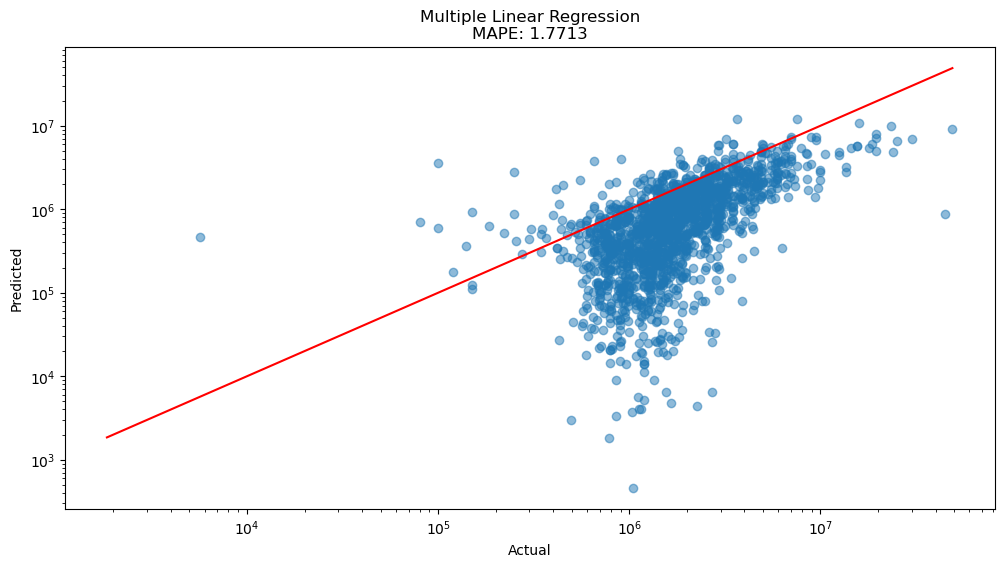

In [324]:
# create a multiple linear regression model with grid search cv
def mlr_model(X_train, y_train, X_test, y_test, cv=5):
    """ Creates a multiple linear regression model with grid search cv
    """
    # create linear regression
    lin_reg = LinearRegression()

    # create a parameter grid
    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [True, False]
    }

    # instantiate the grid search cv object
    grid_mlr = GridSearchCV(lin_reg, param_grid, cv=5, n_jobs=-4, scoring='neg_mean_absolute_percentage_error', verbose=1)

    # fit the model
    grid_mlr.fit(X_train, y_train)

    # best parameters
    best_params = grid_mlr.best_params_
    print("Best parameters: ", best_params)

    # predict on test data
    y_pred_mlr = grid_mlr.predict(X_test)

    # calculate mape
    mape_mlr = round(mean_absolute_percentage_error(y_test, y_pred_mlr), 4)
    print('MAPE: {}'.format(mape_mlr))

    r2_mlr = round(r2_score(y_test, y_pred_mlr), 4)
    print('R2: {}'.format(r2_mlr))
    
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_mlr, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Multiple Linear Regression\nMAPE: {}'.format(mape_mlr))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_mlr, mape_mlr

mlr_regression, mape_mlr = mlr_model(X_train, 
                           y_train, 
                           X_test, 
                           y_test, 
                           cv=5)

mape_lst['Multiple Linear Regression'] = mape_mlr

MAPE gibt her einen durchschnittlichen prozentualen Fehler von 1.77% zwischen den beobachteten (tatsächlichen) Werten und den vorhergesagten Werten an.

### Modell 2: Ridge Regression

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters: {'alpha': 10000.0, 'max_iter': 100, 'random_state': 42}
MAPE: 0.783


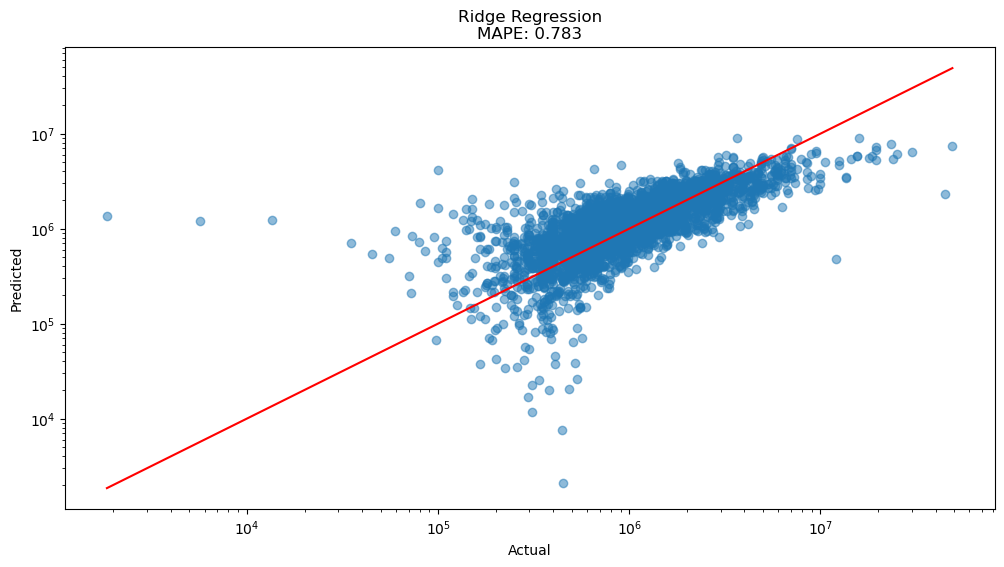

In [249]:
def ridge_model(X_train, y_train, X_test, y_test, alphas=[1], cv=5, iterations=[100]):
    """ Creates a Ridge regression model with grid search cv
    """
    ridge = Ridge()

    param_grid = {
        'alpha': alphas,
        #'fit_intercept': [True, False],
        #'positive': [True, False],
        'max_iter': iterations,
        'random_state': [42]
    }

    grid_ridge = GridSearchCV(ridge, param_grid, cv=cv, n_jobs=5, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_ridge.fit(X_train, y_train)

    best_params = grid_ridge.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_ridge = grid_ridge.predict(X_test)

    mape_ridge = round(mean_absolute_percentage_error(y_test, y_pred_ridge), 4)
    print('MAPE: {}'.format(mape_ridge))

    r2_ridge = round(r2_score(y_test, y_pred_ridge), 4)
    print('R2: {}'.format(r2_ridge))

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_ridge, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Ridge Regression\nMAPE: {}'.format(mape_ridge))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_ridge, mape_ridge


ridge_regression, mape_ridge = ridge_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    alphas=np.linspace(1000, 10000, 500),
    cv=5,
    iterations=[100])

mape_lst['Ridge Regression'] = mape_ridge

### Modell 3: Lasso Regression
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [278]:
def lasso_model(X_train, y_train, X_test, y_test, alphas=[1], cv=5, iterations=[1000]):
    """ Creates a Lasso regression model with grid search cv
    """
    lasso = Lasso()

    param_grid = {
        'alpha': alphas,
        #'fit_intercept': [True, False],
        'max_iter': iterations,
        'random_state': [42],
        #'selection': ['random', 'cyclic']
    }

    grid_lasso = GridSearchCV(lasso, param_grid, cv=cv, n_jobs=5, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_lasso.fit(X_train, y_train)

    best_params = grid_lasso.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_lasso = grid_lasso.predict(X_test)

    mape_lasso = round(mean_absolute_percentage_error(y_test, y_pred_lasso), 4)
    print('MAPE: {}'.format(mape_lasso))

    r2_lasso = round(r2_score(y_test, y_pred_lasso), 4)
    print('R2: {}'.format(r2_lasso))

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_lasso, alpha=0.5)

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Lasso Regression\nMAPE: {}'.format(mape_lasso))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_lasso, mape_lasso


lasso_regression, mape_lasso = lasso_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    alphas=np.linspace(100, 100000, 1000), 
    cv=5,
    iterations=[100]
)

mape_lst['Lasso Regression'] = mape_lasso

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

### Modell 4: XGBoost
[Dokumentation](https://xgboost.readthedocs.io/en/latest/)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 42}
MAPE: 0.4786


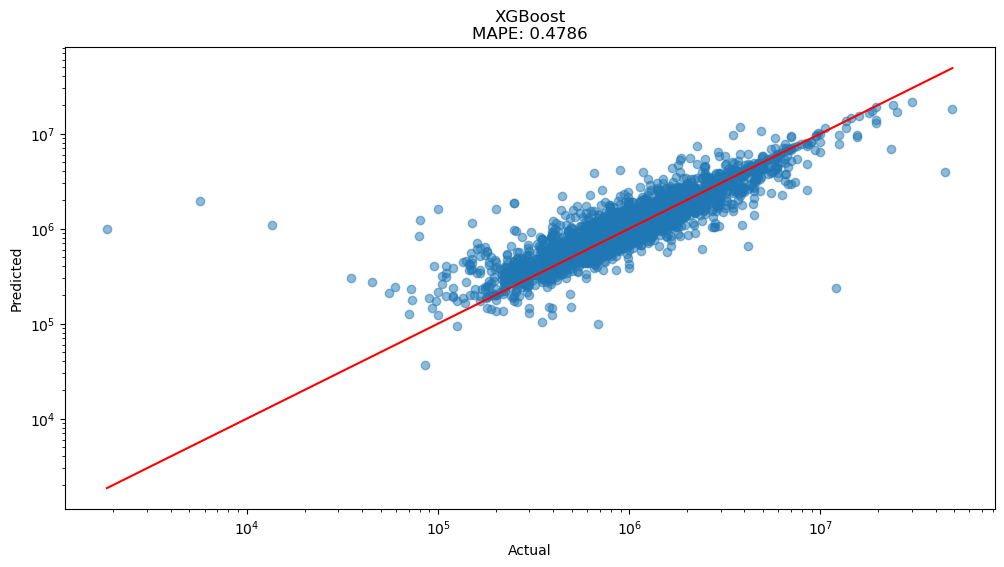

In [302]:
def xgb_model(X_train, y_train, X_test, y_test, cv=5, max_depth=[12], learning_rate=[0.1], booster=['gbtree']):
    """ Creates a XGBoost model with grid search cv
    """
    xgb = XGBRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'booster': booster,
        'random_state': [42]
    }

    grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, n_jobs=8, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_xgb.fit(X_train, y_train)

    best_params = grid_xgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_xgb = grid_xgb.predict(X_test)

    mape_xgb = round(mean_absolute_percentage_error(y_test, y_pred_xgb), 4)
    print('MAPE: {}'.format(mape_xgb))

    r2_xgb = round(r2_score(y_test, y_pred_xgb), 4)
    print('R2: {}'.format(r2_xgb))

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_xgb, alpha=0.5)

    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('XGBoost\nMAPE: {}'.format(mape_xgb))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_xgb, mape_xgb

xgb_regression, mape_xgb = xgb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    max_depth = [None, 6, 9, 12, 15],
    learning_rate = [0.1],
    booster = ['gbtree']
)

mape_lst['XGBoost'] = mape_xgb

### XGBoost Feature Importance

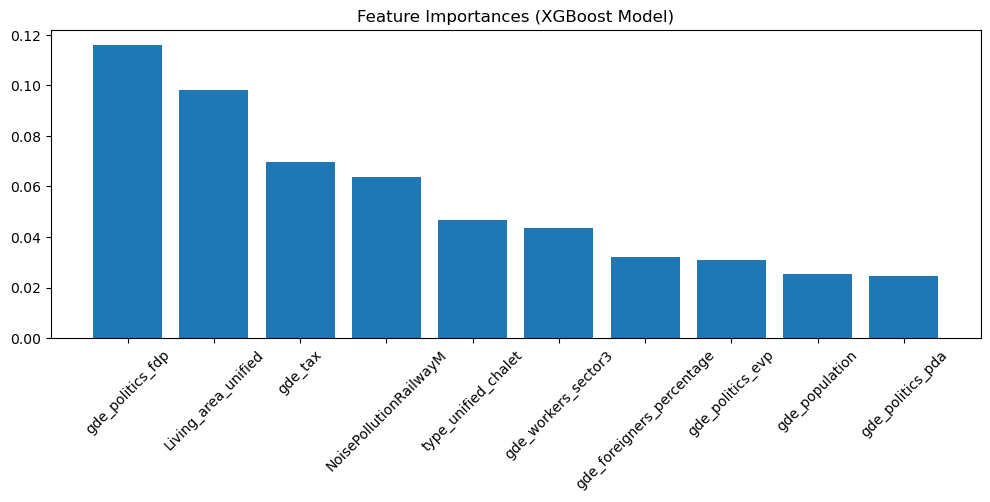

In [343]:
# Extract the best estimator from the GridSearchCV object
best_xgb_model = xgb_regression.best_estimator_

# Get feature importances
importances = best_xgb_model.feature_importances_.argsort()[::-1][:10]

# add to dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns[importances], 'importance': best_xgb_model.feature_importances_[importances]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 4))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importances (XGBoost Model)')
plt.show()

### Modell 5: Random Forest
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'random_state': 42}
MAPE: 0.49


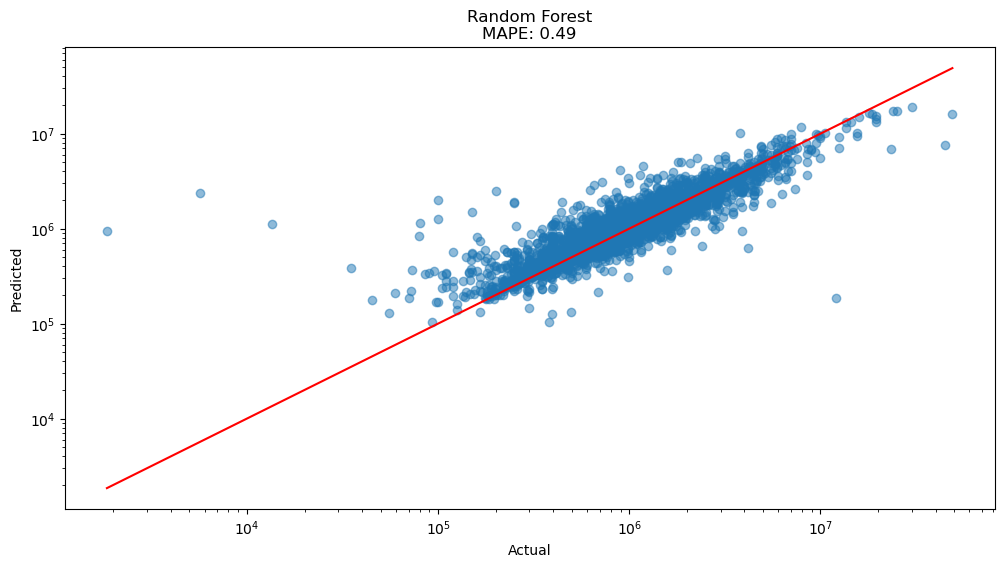

In [315]:
def rf_model(X_train, y_train, X_test, y_test, cv=5):
    """ Creates a Random Forest model with grid search cv
    """
    rf = RandomForestRegressor()

    param_grid = {
        'random_state': [42]
    }

    grid_rf = GridSearchCV(rf, param_grid, cv=cv, n_jobs=5, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_rf.fit(X_train, y_train)

    best_params = grid_rf.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_rf = grid_rf.predict(X_test)

    mape_rf = round(mean_absolute_percentage_error(y_test, y_pred_rf), 4)
    print('MAPE: {}'.format(mape_rf))

    r2_rf = round(r2_score(y_test, y_pred_rf), 4)
    print('R2: {}'.format(r2_rf))

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_rf, alpha=0.5)

    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest\nMAPE: {}'.format(mape_rf))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_rf, mape_rf

rf_regression, mape_rf = rf_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
)

mape_lst['Random Forest'] = mape_rf

### Random Forest Feature Importance

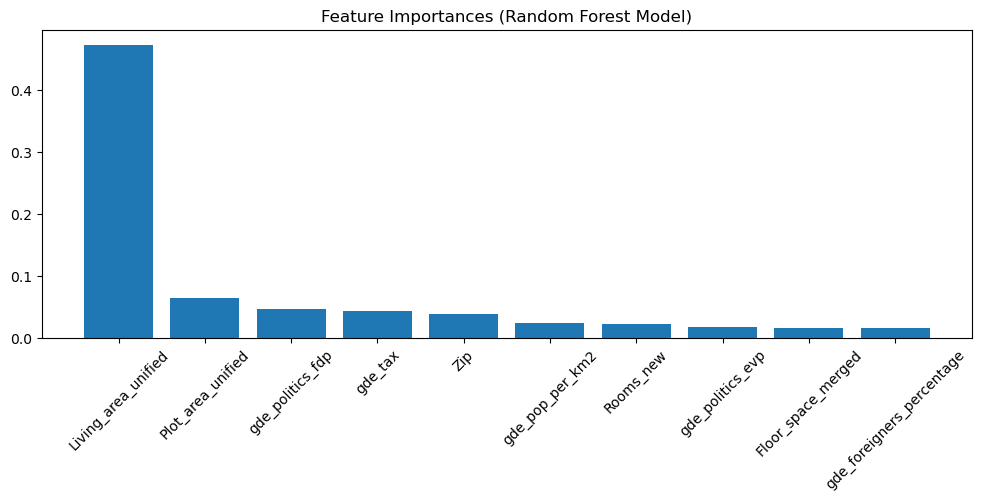

In [342]:
# feature importances for random forest
best_rf_model = rf_regression.best_estimator_.feature_importances_.argsort()[::-1][:10]

# add to dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns[best_rf_model], 'importance': rf_regression.best_estimator_.feature_importances_[best_rf_model]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 4))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importances (Random Forest Model)')
plt.show()

### Modell 6: Hist Gradient Boosting Regression
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaf_nodes': 50, 'min_samples_leaf': 50, 'random_state': 42}
MAPE: 0.5539
R2: 0.6665


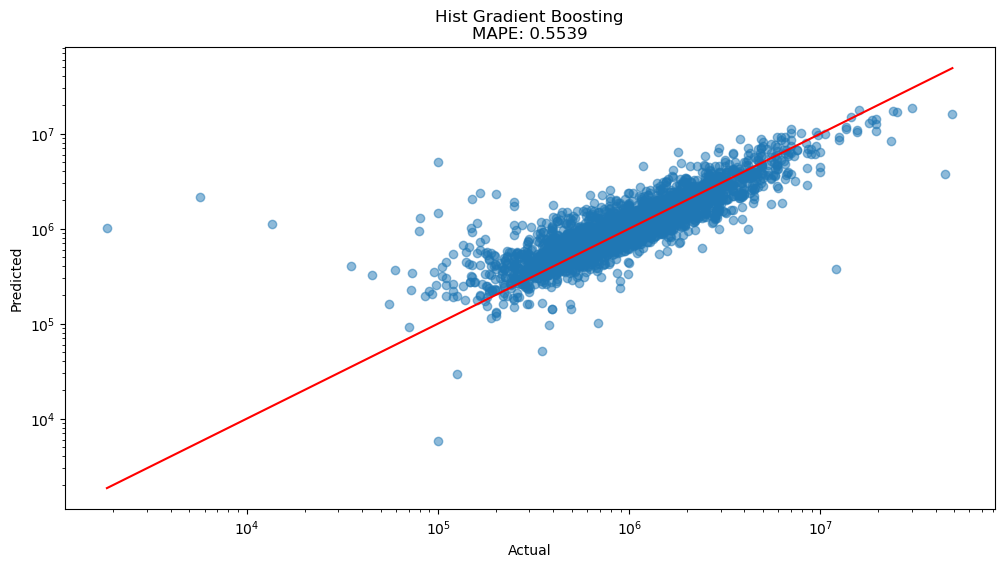

In [354]:
# hist gradient boosting model
def hgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv=5, 
        max_depth=[None], 
        learning_rate=[0.1], 
        l2_regularization=[0.0], 
        max_leaf_nodes=[31],
        min_samples_leaf=[20]):
    
    """ Creates a Hist Gradient Boosting model with grid search cv
    """
    hgb = HistGradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'l2_regularization': l2_regularization,
        'max_leaf_nodes': max_leaf_nodes,
        'min_samples_leaf': min_samples_leaf,
        'random_state': [42]
    }

    grid_hgb = GridSearchCV(hgb, param_grid, cv=cv, n_jobs=8, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_hgb.fit(X_train, y_train)

    best_params = grid_hgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_hgb = grid_hgb.predict(X_test)

    mape_hgb = round(mean_absolute_percentage_error(y_test, y_pred_hgb), 4)
    print('MAPE: {}'.format(mape_hgb))

    r2_hgb = round(r2_score(y_test, y_pred_hgb), 4)
    print('R2: {}'.format(r2_hgb))

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_hgb, alpha=0.5)

    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Hist Gradient Boosting\nMAPE: {}'.format(mape_hgb))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_hgb, mape_hgb

hgb_regression, mape_hgb = hgb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    max_depth = [None, 3, 6, 9],
    learning_rate = [0.1],
    l2_regularization = [0.0, 0.1],
    max_leaf_nodes = [31, 50],
    min_samples_leaf = [20, 50],
)

mape_lst['Hist Gradient Boosting'] = mape_hgb

### Modell 7: Gradient Boosting Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'random_state': 42}
MAPE: 0.501


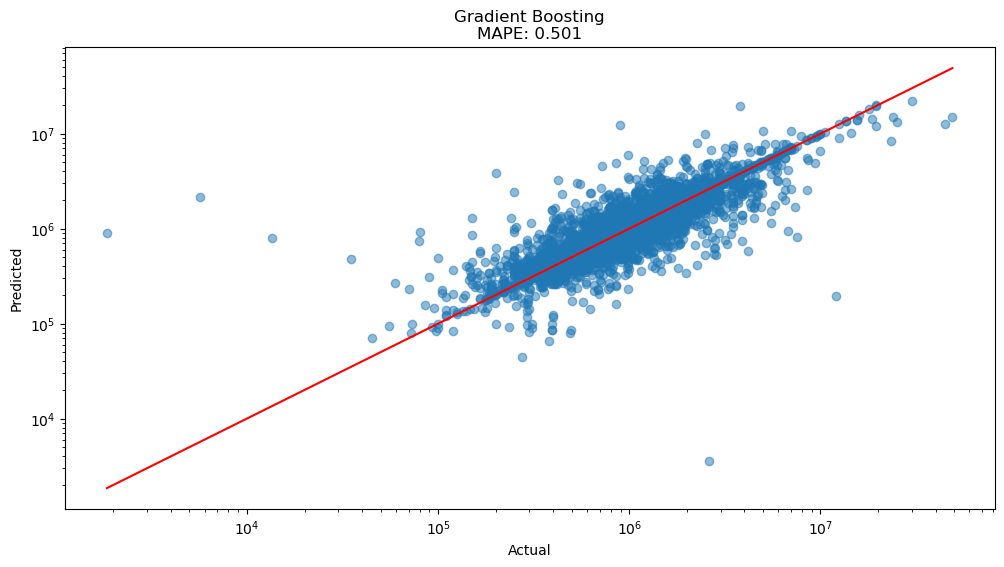

In [320]:
# gradient boosting model
def gb_model(X_train, y_train, X_test, y_test, cv=5, max_depth=[None], learning_rate=[0.1]):
    """ Creates a Gradient Boosting model with grid search cv
    """
    gb = GradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [42]
    }

    grid_gb = GridSearchCV(gb, param_grid, cv=cv, n_jobs=8, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_gb.fit(X_train, y_train)

    best_params = grid_gb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_gb = grid_gb.predict(X_test)

    mape_gb = round(mean_absolute_percentage_error(y_test, y_pred_gb), 4)
    print('MAPE: {}'.format(mape_gb))

    r2_gb = round(r2_score(y_test, y_pred_gb), 4)
    print('R2: {}'.format(r2_gb))

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_gb, alpha=0.5)

    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting\nMAPE: {}'.format(mape_gb))
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return grid_gb, mape_gb

gb_regression, mape_gb = gb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5
)

mape_lst['Gradient Boosting'] = mape_gb

## Modelle vergleichen

In [326]:
mape_lst

{'Multiple Linear Regression': 1.7713}

## Genauer Anschauen:
### Hist Gradient Boosting Regressor
### Regularisierungen
### Hyperparameter Tuning